# Music Categorization by Competitive Neural Network Approach
#### Alex Fick, 24F, Comp Neuro Final Project


# 1. Set-Up

First, let's do a little set-up. We are going to install MiniSom, a lightweight package for creating and training Self-Organizing Maps (SOMs). This library provides an intuitive API for SOMs and is well-suited for use in Python.

This project was targeted to be a competitive network for song clustering. Self-Organizing Maps are a specific implementation of a competitive network, and MiniSom provides an easy-to-use framework, which is why I chose it for the purposes of this project.

One key feature that sets SOMs apart from the competitive networks we studied in class is the **neighborhood function**. In a SOM, after identifying the winning neuron (called the Best Matching Unit, or BMU), we update not only the BMU but also its neighbors. This neighborhood adjustment introduces a **topological structure** to the map, ensuring that clusters closer together in the SOM are more similar, while clusters farther apart represent more distinct groups.

Then, we are going to install the necessary packages, and read in our data, which I have hosted on GitHub for easy access.

In [1]:
pip install MiniSom


In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom

import pandas as pd
data = pd.read_csv('https://github.com/afick/compneurofinal/raw/refs/heads/main/SongCSV.csv', on_bad_lines='skip')


Now, let's preview the data.

In [3]:
data

,SongNumber,SongID,AlbumID,AlbumName,ArtistID,ArtistLatitude,ArtistLocation,ArtistLongitude,ArtistName,ArtistMbTags,...,ModeConfidence,Danceability,Duration,KeySignature,KeySignatureConfidence,Tempo,TimeSignature,TimeSignatureConfidence,Title,Year
0,1,b'SOGSMXL12A81C23D88',275907.0,b'Je Sais Que La Terre Est Plate (Deluxe)',b'AREJXK41187B9A4ACC',46.71067,b'France',1.71819,b'Rapha\xc3\xabl',[],...,0.556,0.0,148.74077,0.0,0.591,124.059,4.0,0.372,b'Je Sais Que La Terre Est Plate',2008.0
1,2,b'SOMBCOW12AAF3B229F',382807.0,b'Comme Vous',b'AR2XRFQ1187FB417FE',NaN,b'',NaN,b'Julie Zenatti',[],...,0.670,0.0,252.99546,1.0,0.429,80.084,4.0,0.533,b'On Efface',2004.0
2,3,b'SOEYIHF12AB017B5F4',490659.0,b'Watkins Ale - Music of the English Renaissa...,b'ARODOO01187FB44F4A',NaN,b'',NaN,b'The Baltimore Consort',[],...,0.000,0.0,78.02730,3.0,0.000,54.874,4.0,0.000,b'Howells Delight',0.0
3,4,b'SODJYEC12A8C13D757',116616.0,"bDon't Worry Lady""""",b'ARJGW911187FB586CA',NaN,b'',NaN,b'I Hate Sally',[],...,0.385,0.0,163.63057,7.0,0.380,77.150,3.0,0.369,b'Martha Served',2007.0
4,5,b'SOGSOUE12A58A76443',767122.0,b'Easy Listening: Cartoon Songs',b'AR9HQ6Y1187FB3C2CB',NaN,b'',NaN,b'Orlando Pops Orchestra',[],...,0.528,0.0,199.99302,10.0,0.551,120.382,4.0,1.000,b'Zip-A-Dee-Doo-Dah (Song of the South)',0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11148,9997,b'SOIFMVY12A8AE467B1',278645.0,b'October',b'ARUJ5A41187FB3F5F1',NaN,b'Dublin Ireland',NaN,b'U2',[b'irish' b'rock' b'ireland' b'irlandais' b'cl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11149,b'\xc3\xa9ire' b'irlande'],0.0,0.0,133.596,0,0.65900,0.0,142.23628,9,0.756,...,1981.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11150,9998,b'SOGVDLQ12A58A7E3C5',258315.0,"bAin't It Beautiful""""",b'ARWC3XN1187B9A8D82',40.71455,b'NY - New York City',-74.00712,b'ZO2',[],...,0.298,0.0,346.51383,7.0,0.180,88.344,5.0,0.307,"bComin' Home""""",2007.0
11151,9999,b'SOVVGSH12A8C14085F',219488.0,bBrazil Classics 7: What's Happening in Pernam...,b'AR0GGKI1187FB391D5',NaN,b'',NaN,b'Eddie',[],...,0.242,0.0,243.17342,8.0,0.042,160.089,4.0,0.484,b'Pode Me Chamar',2007.0


# 2. Data Cleanup

As you can tell, this data is a bit messy. Also, only numeric data is going to work by default with the MiniSOM. So, lets keep track of the identifying information about each song (album name, song title, and artist name). Then, we can take only the numeric data, drop the data that has missing values, and then standardize the data we are going to work with.

In [4]:
identifiers = data[['AlbumName', 'Title', 'ArtistName' ]]
data['OriginalIndex'] = data.index  # Add an index column
X_numeric = data.select_dtypes(include=[np.number])
X_numeric = X_numeric[~np.isnan(X_numeric).any(axis=1)]
indices = X_numeric['OriginalIndex'].values  # Store original indices
X_numeric = X_numeric.drop(columns=['OriginalIndex', 'AlbumID'])
identifiers = identifiers.iloc[indices]  # Filter metadata to match the processed rows

# Scale only the numeric data
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_numeric)

X = X_scaled

So, the remaining data has the following shape:

In [5]:
X.shape

(3429, 14)

# 3. Optimizing our Search

As we learned in class, we need to define what the dimensions of our search space should be, i.e., how many neurons or clusters we want to train. Without knowing much about the data, this is a difficult task. I personally do not know how many distinct but identifiable categories of music there are. So, let's explore a few different possible SOM sizes, and see how it effects the error of the model. Then, we can just choose the size with the lowest error, and continue on analyzing the output from that one.

To calculate error, there are two key metrics:


*   Quantization error: This describes the average distance between each data point and its Best Matching Unit (BMU) on the SOM. It reflects how accurately the neurons represent the data points. A lower quantization error indicates a better representation of the data by the SOM.

*   Topological error: This describes how well the SOM preserves the topological relationships of the data. Specifically, it measures the proportion of input data points where the first and second closest neurons are not adjacent on the SOM grid. A lower topological error indicates that the map maintains the relationships between similar data points, preserving the structure of the data.

As we will notice, quantization error naturally gets lower as the SOM becomes higher dimensional; if we had a cluster for each data point, then we could minimize the error to 0. However, its pretty obvious this wouldn't be particularly useful, and this would come at the cost of topological error. So, instead, we are going to consider a weighted combination error of the two, which I have defined as

\begin{equation}
E(Q, T) = 0.2 \cdot Q + 0.8 \cdot T
\end{equation}

Here:
- $Q$ represents the quantization error.
- $T$ represents the topological error.

I don't have a great justification for this weighting scheme, except that it seems to effectively capture a place where both errors seem to be plateauing.



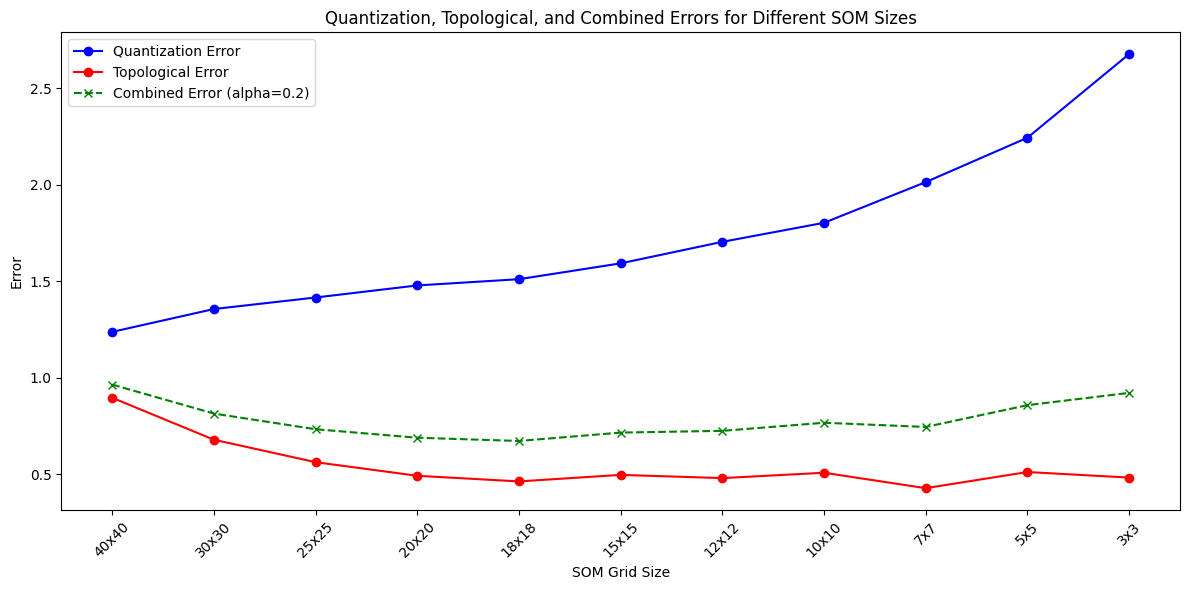

In [6]:
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt

# Calculate the combined error with a given alpha value
def combined_error(quant_error, topo_error, alpha=0.2):
    # alpha controls the weight of quantization vs. topological error
    return alpha * quant_error + (1 - alpha) * topo_error

# Train SOM and calculate both quantization and topological error
def train_som(som_x, som_y, data, num_iterations=3000):
    som = MiniSom(som_x, som_y, data.shape[1], sigma=1.0, learning_rate=0.5)
    som.random_weights_init(data)
    som.train_random(data, num_iterations)  # Train the SOM
    quantization_error = som.quantization_error(data)  # Calculate final quantization error
    topo_error = som.topographic_error(data)  # Calculate final topological error
    return quantization_error, topo_error

sizes = [(40,40), (30,30), (25,25), (20,20), (18,18), (15,15), (12,12), (10, 10), (7, 7), (5, 5), (3, 3)]
som_results = {}

quantization_errors = []
topological_errors = []
combined_errors = []
size_labels = []

# Train a SOM for each size, and get the errors accordingly
for size in sizes:
    som_x, som_y = size
    quant_error, topo_error = train_som(som_x, som_y, X_scaled, num_iterations=3000)
    som_results[size] = {
        'quantization_error': quant_error,
        'topological_error': topo_error
    }
    quantization_errors.append(quant_error)
    topological_errors.append(topo_error)
    # Calculate combined error using alpha as 0.2
    combined_errors.append(combined_error(quant_error, topo_error, alpha=0.2))
    size_labels.append(f"{som_x}x{som_y}")

# Plot errors for each grid size
plt.figure(figsize=(12, 6))
plt.plot(size_labels, quantization_errors, label='Quantization Error', color='blue', marker='o')
plt.plot(size_labels, topological_errors, label='Topological Error', color='red', marker='o')
plt.plot(size_labels, combined_errors, label='Combined Error (alpha=0.2)', color='green', marker='x', linestyle='--')
plt.title("Quantization, Topological, and Combined Errors for Different SOM Sizes")
plt.xlabel('SOM Grid Size')
plt.ylabel('Error')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

As we can see in the graph above, the best size for our SOM is the following:

In [7]:
best_size = min(som_results, key=lambda size: combined_error(som_results[size]['quantization_error'], som_results[size]['topological_error'], alpha=0.2))
best_size

(18, 18)

# 4. Running the Model

Now that we have found the best size for our SOM, we can use that size to train and run our model.

In [8]:
# Define the SOM dimensions based on the best performer
som_x, som_y = best_size
som = MiniSom(som_x, som_y, X.shape[1], sigma=1.0, learning_rate=0.5)

# Initialize the SOM with random weights
som.random_weights_init(X)

# Train the SOM
num_iterations = 3000
som.train_random(X, num_iterations)


Top 3 BMUs with the highest number of mappings:
1. BMU at (2, 10) with 27 mappings
2. BMU at (8, 6) with 27 mappings
3. BMU at (9, 3) with 26 mappings


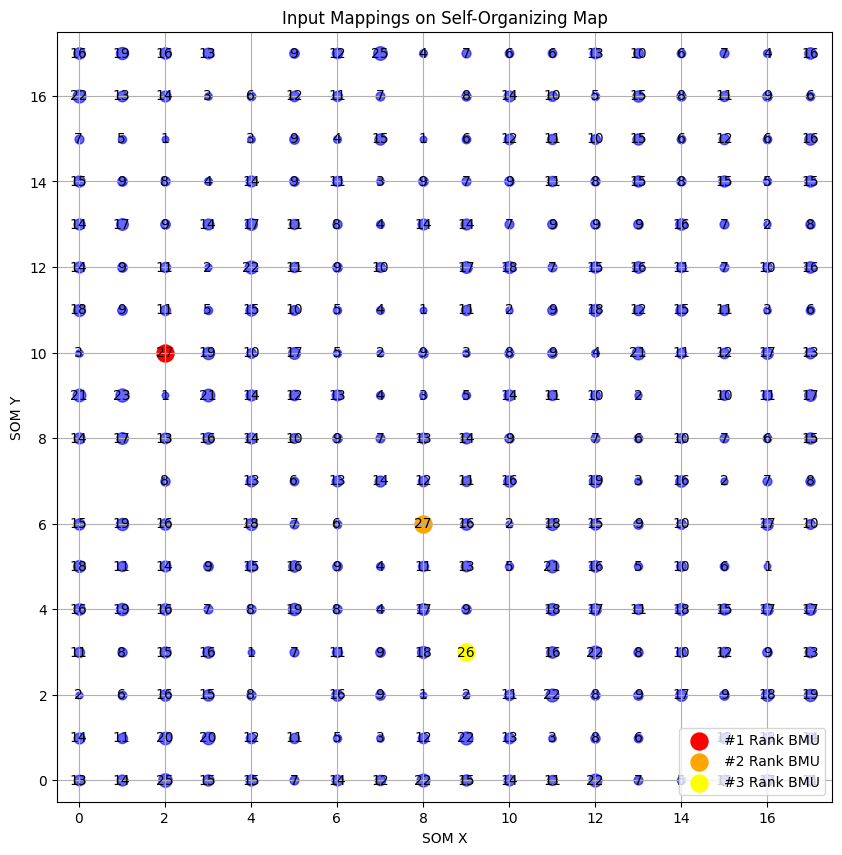

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Find BMU coordinates for each input
bmu_mappings = defaultdict(list)  # To store inputs that map to each BMU
for i, x in enumerate(X_scaled):
    bmu = som.winner(x)  # Get BMU for each input
    bmu_mappings[bmu].append(i)  # Map input index to BMU coordinates

# Sort BMUs by the number of inputs that map to them
sorted_bmus = sorted(bmu_mappings.items(), key=lambda item: len(item[1]), reverse=True)

# Get the top 3 BMU locations with the highest number of mappings
top_3_bmus = sorted_bmus[:3]

# Print the top 3 BMUs and their counts
print("Top 3 BMUs with the highest number of mappings:")
for i, ((x, y), indices) in enumerate(top_3_bmus, start=1):
    print(f"{i}. BMU at ({x}, {y}) with {len(indices)} mappings")

# Visualize inputs on the SOM grid
plt.figure(figsize=(10, 10))
plt.title("Input Mappings on Self-Organizing Map")

# Plot each BMU and show count of inputs that map to each BMU
for (x, y), indices in bmu_mappings.items():
    plt.scatter(x, y, c='blue', s=20 + 3 * len(indices), alpha=0.6)  # Adjust size based on count
    plt.text(x, y, str(len(indices)), ha='center', va='center', color='black')

# Highlight top 3 BMUs in a different color
i = 1
colors = ['red', 'orange', 'yellow']
for (x, y), _ in top_3_bmus:
    plt.scatter(x, y, c=colors[i-1], s=150, marker='o', label=f"#{i} Rank BMU")
    i += 1

plt.xlim(-0.5, som_x - 0.5)
plt.ylim(-0.5, som_y - 0.5)
plt.xlabel("SOM X")
plt.ylabel("SOM Y")
plt.grid()
plt.legend()
plt.show()


We can see in the graph above how many songs fall into each cluster. We will inspect the top three soon, but first let's define a couple functions to clean up some of our data and present it nicely.

In [10]:
# Function to clean up byte strings and remove unwanted characters
def clean_string(s):
    if isinstance(s, bytes):  # Check if it's a byte string
        s = s.decode('utf-8')  # Decode to regular string
    # Remove any extra quotes or leading/trailing whitespace
    return s.strip("'\"b")

# Apply the cleaning function to each column in the identifiers DataFrame
identifiers = identifiers.applymap(clean_string)

# Create a df for each cluster, columns are the index from original data,
# the input vector, the album name, song title, and artist name
def create_df(target_bmu):
  mapped_data = []
  for i, x in enumerate(X_scaled):
      if som.winner(x) == target_bmu:
          song_data = X_scaled[i]
          song_info = identifiers.iloc[i]
          data_entry = {
              'Index': i,
              'Data': list(song_data),
              **song_info.to_dict()
          }
          mapped_data.append(data_entry)

  mapped_df = pd.DataFrame(mapped_data)

  mapped_df.rename(columns={
        'AlbumName': 'Album Name',
        'Title': 'Song Title',
        'ArtistName': 'Artist Name'
    }, inplace=True)
  return mapped_df

<ipython-input-10-c731c8763ffd>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  identifiers = identifiers.applymap(clean_string)


The next cell shows songs in the cluster with the largest amount of songs.

In [11]:
create_df(top_3_bmus[0][0])

,Index,Data,Album Name,Song Title,Artist Name
0,61,"[1.222164153205276, 1.2442555737585217, -0.388...",Oh! It's A Lovely War (Vol 4.1),Shouther to Shouther (Shoulder to Shoulder),Harry Lauder
1,92,"[1.1181171163099624, 1.261939553961532, -0.340...",Supermassive Black Hole,Supermassive Black Hole (Album Version),Muse
2,161,"[0.9398972115742278, 1.3039598385436741, -0.18...",All i,Chu Hsin,B.A.D.
3,211,"[0.9398972115742278, 1.3039598385436741, -0.32...",Reach For The Ground,Reach For The Ground,The Ghost Of Lemora
4,589,"[0.8847291773824313, 1.3677025362866653, -0.38...",The Lakeshore,Expeditions,From Dying Skies
5,658,"[1.0314842476505133, 1.2836421845957695, -0.26...",Papi Chulo,Papi Chulo (Extended Mix),Lorna
6,812,"[0.9398972115742278, 1.3039598385436741, -0.34...",Tales From The Sick,Go To Hell,Prozak
7,834,"[-0.0004983408160170471, 1.18391127429925, -0....",Behind The Blue,Bulgarian Dream,Kiril Valeri
8,880,"[0.9781011101628995, 1.413003523110361, -0.388...",Nha Vit\xc3\xb3ria,Festa,Gil Semedo
9,953,"[0.05158357396762301, 1.60758325592379, -0.388...",Norma,Bellini: Norma: Vanne_ e li cela entrambi,Vincenzo Bellini


The next cell shows songs in the cluster with the $2^{\text{nd}}$ largest amount of songs.

In [12]:
create_df(top_3_bmus[1][0])

,Index,Data,Album Name,Song Title,Artist Name
0,95,"[-0.3422038660790255, -0.624427267584151, -0.1...",For The Last Time,Yearning Just For You,Bob Wills
1,291,"[-0.04003900770447882, -0.5110222352817989, -0...",Washboard Sam Vol. 2 (1937-1938),I'm On My Way Blues,Washboard Sam
2,347,"[0.2548973998637979, -0.17233578815838718, -0....",The Baroque Beatles,R\xc3\xa9jouissance [I'll Cry Instead],Joshua Rifkin
3,427,"[-0.3973465105595248, -0.5007265292095723, -0....",I Believe To My Soul,The Same Love That Made Me Laugh [LP Version],Irma Thomas
4,449,"[0.3563299312382972, -0.11401849829457876, -0....",In North Carolina,Baby_ Baby_ Baby,Bob Margolin
5,455,"[0.45529204370359416, -0.14125384202810595, -0...",The Greatest Stars Of Folk Music,Tom Dooley,Kingston Trio
6,494,"[-0.3422038660790255, -0.624427267584151, -0.3...",Cotton Eyed Joe,Linda Lou,Bob Wills
7,520,"[-0.20195490933081217, -0.4955165310646077, -0...",Living Country Blues USA Vol. 12 - East Coast ...,Won't You Spread Some Flowers On My Grave,Guitar Slim
8,678,"[-0.45215528033646796, -0.6346462414319437, -0...",South Texas Swing,We Played A Game,Adolph Hofner
9,894,"[-0.025763642527711777, -0.5948723726495059, -...",20 Greatest Hits,Love's Been Good To Me,Carl Belew


The next cell shows songs in the cluster with the $3^{\text{rd}}$ largest amount of songs.

In [13]:
create_df(top_3_bmus[2][0]).head(40)

,Index,Data,Album Name,Song Title,Artist Name
0,128,"[0.44113156697044664, -0.2798050633596702, -0....",Putting It Straight,It Ain't What It Seems,Pat Travers
1,129,"[-0.42814042190615254, -0.49346394406099936, -...",Lonnie Johnson Vol. 2 (1926 - 1927),South Bound Water,Lonnie Johnson
2,165,"[0.21863327521822049, -0.18671488747620685, -0...",La bonne cuisine,Trois No\xc3\xabls qu\xc3\xa9b\xc3\xa8cois (tr...,Catherine King/Matthew Schwinghammer/The Ameri...
3,351,"[-0.039976168169018514, -0.2879852380254327, -...",Josh White Vol. 3 1935-1940,My Soul Is Gonna Live With God,Josh White
4,416,"[0.3330044034696968, -0.1178633022798229, -0.2...",Another Somebody Done Somebody Wrong Song,My Melody Of Love,Ray Conniff
5,876,"[0.13966302142822115, -0.23272005231788503, -0...",All The Good Times,Kassie Jones,Alice Stuart
6,904,"[0.15741741179546634, -0.6230319000757597, -0....",This Will Be Laughing Week,This Will Be Laughing Week,Ultimate Fakebook
7,924,"[0.19470029860683788, -0.4207949306990263, -0....",The Age Of Style - Hits of the 30s,Would You Like To Take A Walk?,Marion Harris
8,1135,"[-0.46173100995215066, -0.6616535865506813, -0...",Butthole Surfers + PCPpep,Wichita Cathedral [live],Butthole Surfers
9,1207,"[0.2548973998637979, -0.17233578815838718, -0....",Groovin,I'm So Happy Now (Single Version),The Rascals


# 5. Analysis, Discussion, and Wrap-up

From the above dataframes, I sampled several songs by searching for them on YouTube. In general, I thought the model performed decently well; the songs in the same dataframe often had a vaguely similar vibe. However, the songs are not as similar as you might expect, and there are a few reasons as to why I think this might be.

1. The data is pretty old, and so songs from different genres sound more similar than they seem to today. As a result, songs that someone might manually classify into different groups might be flushed into the same group by this model.
2. The feature space is limited and not very informative or precise. There aren't any strong features to distinguish genres, mostly just characteristics that can apply to any song, like what key it is in and when fades start/end, etc. Of course, some genres probably have certain key signatures more than others, and probably have some tendencies with fades and the like, but I think this model / approach would benefit from different data.

## Ideas for future

I have a couple thoughts about similar ideas for a project that might yield more insightful results.

1.  Incorporating song lyrics and using natural language processing techniques, such as sentiment analysis, could provide more meaningful features for clustering. Combining lyrical sentiment with attributes like tempo, peak amplitude, and key signature might create clusters that better capture the "vibe" of the songs.
2. Exploring song waveforms to extract features like spectral content, harmonic structure, or timbral characteristics could provide a more detailed basis for clustering. For example, using short-time Fourier transforms (STFT) or Mel-frequency cepstral coefficients (MFCCs) could reveal patterns in the audio data that align more closely with perceived musical similarity.
3. Using a more recent and diverse dataset, including contemporary genres and trends, might produce more relevant clusters. Streaming platforms often have metadata, such as mood tags or curated playlists, which could be used to supplement feature engineering.

## Final Thoughts

While this project demonstrated the ability of competitive networks to group songs based on their features, the results highlight the importance of meaningful and descriptive input data. By refining the feature set and exploring alternative clustering methods, future projects could yield deeper insights into musical relationships. This project has provided a solid foundation and many ideas for further exploration, blending data science with musical analysis.